In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import pandas as pd
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
from PIL import Image
from glob import glob
import wandb
import re
from adjustText import adjust_text
import seaborn as sns
import scipy
import statannot
import argparse
import sys
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.utils_hcp import *
from MedSAM_HCP.dataset import *
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

/gpfs/home/kn2347/.conda/envs/medsam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load_model_from_label_and_type('singletask_unet', 1)

parser = argparse.ArgumentParser()
parser.add_argument('--df_starting_mapping_path', type=str, default = '/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv', help = 'Path to dataframe holding the integer labels in the segmentation numpy files and the corresponding text label, prior to subsetting for only the labels we are interested in.')
parser.add_argument('--df_desired_path', type=str, default = '/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')

args = {'df_starting_mapping_path': '/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv',
        'df_desired_path': '/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv',
        'train_test_splits': '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle',
        'world_size': None}

In [5]:
model_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_experiments_singletask_unet_8-21-24/1/0.1/singletask_unet-label1_subsample_0.1%_training-20240822-013042-best_model.pth'
model = load_model_from_label_and_type('singletask_unet', 1, path= model_path)
model = load_model_from_label_and_type('singletask_unprompted', 1, path='/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_experiments_singletask_medsam_8-16-24/1/0.1/singletask_medsam_no_yolo-label1_subsample_0.1%_training-20240818-143824/medsam_model_best_sam_readable.pth')
df_hcp, df_desired, NUM_CLASSES, label_converter, dataset = load_data_from_label_and_type('singletask_unprompted', 1, 'val', args)

_, _, _, _, dataset2 = load_data_from_label_and_type('singletask_unet', 1, 'val', args, data_path = None)


model path in readable format already
model path in readable format already
OKER (28416, 4)
OKER (11807, 5)


In [97]:
batch_sz = 16   
val_dataloader = DataLoader(
    dataset,
    batch_size = batch_sz,
    shuffle = False,
    num_workers = 0,
    pin_memory = True
)


In [105]:
tot_neg_ex = 0
tot_pos_ex = 0
c1 = []
c2 = []
for step, tup in enumerate(tqdm(val_dataloader)):
    image_embedding, gt2D, boxes, _ = tup # "image_embedding" here is really just the tensor of the raw image since unet does not do pre-embedding
    image_embedding, gt2D = image_embedding.cuda(), gt2D.cuda()
        
    boxes = boxes.cuda()
    pred = torch.as_tensor(
        medsam_inference(model, image_embedding, boxes, 256, 256, as_one_hot=True,
        model_trained_on_multi_label=False, num_classes = 1),
        dtype=torch.uint8
    ).cuda()
    #pred = model(image_embedding).cuda()
    #pred = (pred > 0.5).to(torch.uint8)

    B, classes, H, W = gt2D.shape
    gt2D_flattened = gt2D.view(B, classes, -1)
    is_negative_examples = (gt2D_flattened == 0).all(dim=2)

    tot_neg_ex += is_negative_examples.all(dim=1).sum()
    tot_pos_ex += batch_sz - is_negative_examples.all(dim=1).sum()

    c1.append(dice_scores_multi_class(pred, gt2D, eps=1e-6, mask_empty_class_images_with_nan = False))
    c2.append(dice_scores_multi_class(pred, gt2D, eps=1e-6, mask_empty_class_images_with_nan = True))
    if step % 100 == 0:
        print(torch.concat(c1).nanmean(dim=0))
        print(torch.concat(c2).nanmean(dim=0))
        print(f'{tot_neg_ex} {tot_pos_ex}')
        print('=================')




  0%|          | 1/1776 [00:01<47:53,  1.62s/it]

tensor([1.])
tensor([nan])
16 0


  6%|▌         | 101/1776 [02:00<30:56,  1.11s/it]

tensor([0.8161])
tensor([0.7831])
970 646


  7%|▋         | 122/1776 [02:25<32:48,  1.19s/it]


KeyboardInterrupt: 

In [90]:
tot_neg_ex = 0
tot_pos_ex = 0
c1 = []
c2 = []
for step, tup in enumerate(tqdm(val_dataloader)):
    image_embedding, gt2D, boxes, _ = tup # "image_embedding" here is really just the tensor of the raw image since unet does not do pre-embedding
    image_embedding, gt2D = image_embedding.cuda(), gt2D.cuda()

    boxes = boxes.cuda()
    pred = torch.as_tensor(
        medsam_inference(model, image_embedding, boxes, 256, 256, as_one_hot=True,
        model_trained_on_multi_label=False, num_classes = 1),
        dtype=torch.uint8
    ).cuda()
    #pred = model(image_embedding).cuda()
    #pred = (pred > 0.5).to(torch.uint8)

    B, classes, H, W = gt2D.shape
    gt2D_flattened = gt2D.view(B, classes, -1)
    is_negative_examples = (gt2D_flattened == 0).all(dim=2)

    tot_neg_ex += is_negative_examples.all(dim=1).sum()
    tot_pos_ex += batch_sz - is_negative_examples.all(dim=1).sum()

    c1.append(dice_scores_multi_class(pred, gt2D, eps=1e-6, mask_empty_class_images_with_nan = False))
    c2.append(dice_scores_multi_class(pred, gt2D, eps=1e-6, mask_empty_class_images_with_nan = True))
    if step % 100 == 0:
        print(torch.concat(c1).nanmean(dim=0))
        print(torch.concat(c2).nanmean(dim=0))
        print(f'{tot_neg_ex} {tot_pos_ex}')
        print('=================')




  0%|          | 1/738 [00:00<02:51,  4.30it/s]

tensor([0.4685])
tensor([0.4685])
0 16


 14%|█▎        | 101/738 [00:59<09:29,  1.12it/s]

tensor([0.6108])
tensor([0.6131])
6 1610


 27%|██▋       | 201/738 [02:05<06:25,  1.39it/s]

tensor([0.6061])
tensor([0.6094])
17 3199


 41%|████      | 301/738 [03:08<05:11,  1.40it/s]

tensor([0.6076])
tensor([0.6106])
24 4792


 54%|█████▍    | 401/738 [04:14<03:29,  1.61it/s]

tensor([0.6087])
tensor([0.6123])
38 6378


 68%|██████▊   | 501/738 [05:18<02:23,  1.66it/s]

tensor([0.6068])
tensor([0.6102])
45 7971


 81%|████████▏ | 601/738 [06:21<01:45,  1.30it/s]

tensor([0.6063])
tensor([0.6094])
49 9567


 95%|█████████▍| 701/738 [07:27<00:23,  1.61it/s]

tensor([0.6068])
tensor([0.6100])
59 11157


100%|██████████| 738/738 [07:55<00:00,  1.55it/s]


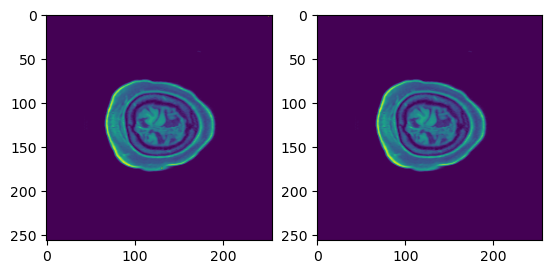

In [64]:
idx = 11
img = image_embedding[idx, 0, :, :].cpu().numpy()
pred_map = pred[idx, 0, :, :].cpu().numpy()
gt = gt2D[idx, 0, :, :].cpu().numpy()

fig, axs = plt.subplots(1,2)
#axs[0].imshow(img)
axs[0].imshow(img)
show_mask(pred_map, axs[0], random_color=False)
axs[1].imshow(img)
show_mask(gt, axs[1], random_color=False)

In [6]:
collector = run_model_over_dataset(model, dataset, 'singletask_unet')

100%|██████████| 738/738 [17:33<00:00,  1.43s/it]


### Section 2: compare datasets experiment

In [14]:
model_path_true = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_singletask_testing_9-3-24_retraining/lr1e-4/singletask_unet-label5-20240903-034705-best_model.pth'
model_path_false = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_singletask_testing_5-26-24/logs_training/lr1e-4/singletask_unet-label5-20240722-172502-best_model.pth'
data_true = '/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_unet.csv'
data_false = '/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/baseline_unet/all_labels_df.csv'
model_true = load_model_from_label_and_type('singletask_unet', 5, path= model_path_true)
model_false = load_model_from_label_and_type('singletask_unet', 5, path= model_path_false)
#model_false = load_model_from_label_and_type('singletask_unprompted', 1, path='/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/subset_experiments_singletask_medsam_8-16-24/1/0.1/singletask_medsam_no_yolo-label1_subsample_0.1%_training-20240818-143824/medsam_model_best_sam_readable.pth')
#df_hcp, df_desired, NUM_CLASSES, label_converter, dataset = load_data_from_label_and_type('singletask_unprompted', 1, 'val', args)

_, _, NUM_CLASSES, _, dataset_true = load_data_from_label_and_type('singletask_unet', 5, 'val', args, data_path = data_true)
_, _, _, _, dataset_false = load_data_from_label_and_type('singletask_unet', 5, 'val', args, data_path = data_false)


model path in readable format already
model path in readable format already
OKER (28416, 4)
OKER (11807, 5)


In [45]:
dataset = dataset_false
model = model_false

batch_sz = 16   
val_dataloader = DataLoader(
    dataset,
    batch_size = batch_sz,
    shuffle = False,
    num_workers = 0,
    pin_memory = True
)

tot_neg_ex = 0
tot_pos_ex = 0
c1 = []
c2 = []
for step, tup in enumerate(tqdm(val_dataloader)):
    image_embedding, gt2D = tup # "image_embedding" here is really just the tensor of the raw image since unet does not do pre-embedding
    image_embedding, gt2D = image_embedding.cuda(), gt2D.cuda()
        
    #boxes = boxes.cuda()

    # pred = torch.as_tensor(
    #     medsam_inference(model, image_embedding, boxes, 256, 256, as_one_hot=True,
    #     model_trained_on_multi_label=False, num_classes = 1),
    #     dtype=torch.uint8
    # ).cuda()

    pred = model(image_embedding).cuda()
    pred = (pred > 0.5).to(torch.uint8)

    B, classes, H, W = gt2D.shape
    gt2D_flattened = gt2D.view(B, classes, -1)
    is_negative_examples = (gt2D_flattened == 0).all(dim=2)

    tot_neg_ex += is_negative_examples.all(dim=1).sum()
    tot_pos_ex += batch_sz - is_negative_examples.all(dim=1).sum()

    c1.append(dice_scores_multi_class(pred, gt2D, eps=1e-6, mask_empty_class_images_with_nan = False))
    c2.append(dice_scores_multi_class(pred, gt2D, eps=1e-6, mask_empty_class_images_with_nan = True))
    if step==10:
       break
    if step % 100 == 0:
        print(torch.concat(c1).nanmean(dim=0))
        print(torch.concat(c2).nanmean(dim=0))
        print(f'{tot_neg_ex} {tot_pos_ex}')
        print('=================')
xd = c2

  0%|          | 1/738 [00:00<03:46,  3.25it/s]

tensor([1.])
tensor([nan])
16 0


  1%|▏         | 10/738 [00:05<06:48,  1.78it/s]


In [52]:
dataset = dataset_true
model = model_false

batch_sz = 16   
val_dataloader = DataLoader(
    dataset,
    batch_size = batch_sz,
    shuffle = False,
    num_workers = 0,
    pin_memory = True
)

tot_neg_ex = 0
tot_pos_ex = 0
c1 = []
c2 = []
for step, tup in enumerate(tqdm(val_dataloader)):
    image_embedding, gt2D = tup # "image_embedding" here is really just the tensor of the raw image since unet does not do pre-embedding
    image_embedding, gt2D = image_embedding.cuda(), gt2D.cuda()
        
    #boxes = boxes.cuda()

    # pred = torch.as_tensor(
    #     medsam_inference(model, image_embedding, boxes, 256, 256, as_one_hot=True,
    #     model_trained_on_multi_label=False, num_classes = 1),
    #     dtype=torch.uint8
    # ).cuda()

    pred = model(image_embedding).cuda()
    pred = (pred > 0.5).to(torch.uint8)

    B, classes, H, W = gt2D.shape
    gt2D_flattened = gt2D.view(B, classes, -1)
    is_negative_examples = (gt2D_flattened == 0).all(dim=2)

    tot_neg_ex += is_negative_examples.all(dim=1).sum()
    tot_pos_ex += batch_sz - is_negative_examples.all(dim=1).sum()

    c1.append(dice_scores_multi_class(pred, gt2D, eps=1e-6, mask_empty_class_images_with_nan = False))
    c2.append(dice_scores_multi_class(pred, gt2D, eps=1e-6, mask_empty_class_images_with_nan = True))
    if step==10:
       break
    if step % 100 == 0:
        print(torch.concat(c1).nanmean(dim=0))
        print(torch.concat(c2).nanmean(dim=0))
        print(f'{tot_neg_ex} {tot_pos_ex}')
        print('=================')
xd2 = c2

  0%|          | 1/1776 [00:00<20:27,  1.45it/s]

tensor([1.])
tensor([nan])
16 0


  1%|          | 10/1776 [00:08<24:50,  1.19it/s]


[tensor([[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]]),
 tensor([[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]]),
 tensor([[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]]),
 tensor([[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
  

In [19]:
concat1 = torch.concat(xd)
concat2 = torch.concat(xd2)

In [40]:
concat1[~torch.isnan(concat1)][:50]

tensor([5.0000e-07, 2.3529e-01, 8.1818e-01, 9.0909e-01, 7.8261e-01, 6.7213e-01,
        7.2093e-01, 7.5000e-01, 7.4107e-01, 6.6917e-01, 6.3950e-01, 6.6667e-01,
        7.6562e-01, 7.8385e-01, 7.6866e-01, 6.9178e-01, 6.9424e-01, 7.0705e-01,
        7.5842e-01, 7.9580e-01, 8.4427e-01, 8.8070e-01, 8.5228e-01, 8.5189e-01,
        8.6405e-01, 9.0601e-01, 8.7560e-01, 8.9247e-01, 9.2510e-01, 9.3597e-01,
        9.3888e-01, 9.2152e-01, 9.3826e-01, 9.4146e-01, 9.5343e-01, 9.4682e-01,
        9.3563e-01, 9.4572e-01, 9.3903e-01, 9.4633e-01, 9.4322e-01, 9.4179e-01,
        9.4925e-01, 9.3893e-01, 9.4334e-01, 9.3710e-01, 1.0000e+00, 8.5714e-01,
        8.4444e-01, 8.5333e-01])

In [42]:
concat1[:172]

tensor([[       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [       nan],
        [ 

In [82]:
_, _, _, _, dataset_false = load_data_from_label_and_type('singletask_unet', 1, 'val', args, data_path = data_false)
_, _, _, _, dataset_true = load_data_from_label_and_type('singletask_unet', 1, 'val', args, data_path = data_true)


In [107]:
pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/medsam/path_df_label1_only_with_bbox.csv')

,Unnamed: 0,id,slice,image_embedding_slice_path,segmentation_slice_path,image_path,bbox_0,bbox_1,bbox_2,bbox_3
0,0,100206,79,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mr...,108,136,129,141
1,1,100206,80,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mr...,94,135,129,141
2,2,100206,81,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mr...,89,133,141,156
3,3,100206,82,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mr...,89,132,145,156
4,4,100206,83,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/100206/mr...,89,132,145,161
...,...,...,...,...,...,...,...,...,...,...
119479,119479,996782,186,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/996782/mr...,140,151,150,164
119480,119480,996782,187,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/996782/mr...,141,151,152,167
119481,119481,996782,188,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/996782/mr...,139,149,150,164
119482,119482,996782,189,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/luilab/karthik/pediatric_seg_proj/h...,/gpfs/data/cbi/hcp/hcp_seg/data_orig/996782/mr...,140,154,149,159


In [83]:
dicto = {}
for i, r in dataset_true.data_frame.iterrows():
    dicto[(r['id'], r['slice'])] = i

In [101]:
uv = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/baseline_unet/all_labels_df.csv')
uv = uv[uv['id'].isin(dataset_false.data_frame['id'].unique())]
grp = uv.groupby('id')['slice'].agg(['min', 'max'])

def getter(ds, id, sliceo):
    return ds[dicto[(id, sliceo)]][1].max()

listo = []
for i,r in grp.iterrows():
    this_sli = r['min']
    prev_sli = r['min']-1
    end_sli = r['max']
    next_sli = r['max']+2

    res = [getter(dataset_true, r.name, prev_sli), getter(dataset_true, r.name, this_sli), getter(dataset_true, r.name, end_sli), getter(dataset_true, r.name, next_sli)]
    res = [x.item() for x in res]
    print(res)
    if res == [0,1,1,0]:
        listo.append(True)
    else:
        listo.append(False)
    #print(dataset_true[dicto[(r.name, this_sli)]][1].max())
    

[0, 1, 1, 0]
[1, 1, 1, 1]
[1, 1, 1, 0]
[0, 0, 1, 0]
[0, 1, 0, 0]
[0, 0, 1, 0]
[0, 1, 1, 0]
[1, 1, 1, 0]
[0, 1, 1, 0]
[0, 1, 0, 0]
[0, 0, 1, 1]
[0, 1, 1, 0]
[1, 1, 1, 0]
[1, 1, 1, 0]
[1, 1, 1, 0]
[1, 1, 1, 0]
[1, 1, 0, 0]
[1, 1, 0, 0]
[1, 1, 0, 0]
[1, 1, 0, 0]
[1, 1, 1, 1]
[1, 1, 0, 0]
[0, 1, 1, 1]
[0, 0, 1, 0]
[0, 0, 1, 1]
[1, 1, 1, 0]
[0, 1, 1, 1]
[1, 1, 1, 0]
[1, 1, 1, 0]
[0, 0, 1, 0]
[1, 1, 1, 1]
[1, 1, 1, 0]
[1, 1, 0, 0]
[1, 1, 1, 0]
[1, 1, 1, 0]
[0, 1, 1, 0]
[1, 1, 0, 0]
[0, 1, 1, 0]
[1, 1, 0, 0]
[1, 1, 0, 0]
[1, 1, 1, 0]
[1, 1, 1, 0]
[0, 1, 0, 0]
[1, 1, 0, 0]
[0, 0, 1, 1]
[1, 1, 0, 0]
[0, 1, 1, 0]
[0, 1, 0, 0]
[0, 1, 1, 0]
[1, 1, 1, 1]
[0, 0, 1, 0]
[1, 1, 0, 0]
[1, 1, 1, 0]
[0, 1, 1, 0]
[0, 1, 0, 0]
[1, 1, 1, 1]
[1, 1, 1, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[1, 1, 1, 0]
[0, 1, 1, 0]
[1, 1, 1, 0]
[0, 1, 1, 0]
[1, 1, 1, 1]
[0, 0, 1, 0]
[1, 1, 1, 0]
[1, 1, 1, 0]
[1, 1, 1, 0]
[0, 1, 1, 1]
[1, 1, 0, 0]
[0, 0, 0, 0]
[1, 1, 1, 0]
[0, 1, 1, 0]
[0, 0, 1, 0]
[0, 1, 0, 0]
[1, 1, 1, 0]
[1, 1, 1, 0]

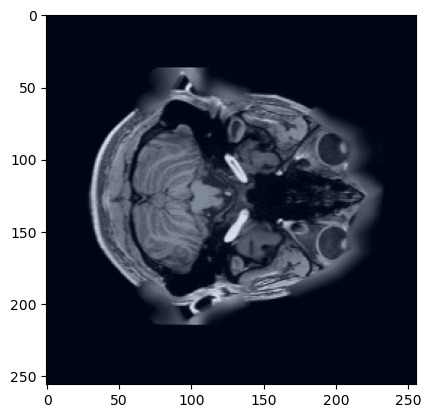

In [92]:
#stuff = dataset_false[109][0].cpu().numpy().transpose((1,2,0))
stuff = dataset_true[190][0].cpu().numpy().transpose((1,2,0))
stuff = (stuff - stuff.min()) / (stuff.max() - stuff.min())
plt.imshow(stuff)

1929
1866


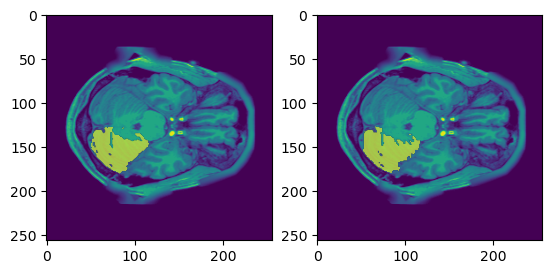

In [55]:

idx = 11
#img = image_embedding[idx, 0, :, :].cpu().numpy()
img = dataset_true[11 + 16*10][0].cpu().numpy()
pred_map = pred[idx, 0, :, :].cpu().numpy()
print(pred_map.sum())
print(gt.sum())
gt = gt2D[idx, 0, :, :].cpu().numpy()

fig, axs = plt.subplots(1,2)
#axs[0].imshow(img)
axs[0].imshow(img)
show_mask(pred_map, axs[0], random_color=False)
axs[1].imshow(img)
show_mask(gt, axs[1], random_color=False)

# CODE

In [31]:
def load_model(model_type, model_path, num_classes):
    result = torch.load(model_path)
    try:
        if 'model' in result.keys():
            splits = model_path.split('/')
            new_path = os.path.join('/'.join(splits[:-1]), f'{splits[-1].split(".pth")[0]}_sam_readable.pth')
            print(f'model path converted to sam readable format and saved to {new_path}')

            result = result['model']

            # now remove the "module." prefix
            result_dict = {}
            for k,v in result.items():
                key_splits = k.split('.')
                assert key_splits[0] == 'module'
                new_k = '.'.join(key_splits[1:])
                result_dict[new_k] = v

            torch.save(result_dict, new_path)
            model_path = new_path

    except (AttributeError):
        # already in the correct format
        print('model path in readable format already')

    if model_type == 'multitask_unprompted':
        model = build_sam_vit_b_multiclass(num_classes, checkpoint=model_path).to('cuda')
    elif model_type == 'pooltask_yolov7_prompted':
        model = build_sam_vit_b_multiclass(num_classes, checkpoint=model_path).to('cuda')
    elif model_type == 'singletask_unet':
        model = torch.load(model_path)
    else:
        # singletask model
        model = build_sam_vit_b_multiclass(3, checkpoint=model_path).to('cuda')



    model.eval()
    return model
def load_model_from_label_and_type(model_type, label, path = None):
    assert model_type in ['singletask_unprompted', 'multitask_unprompted',
                'singletask_medsam_prompted', 'singletask_yolov7_prompted',
                'singletask_yolov7_longer_prompted', 'pooltask_yolov7_prompted',
                'singletask_unet']
    
    if model_type == 'singletask_unprompted':
        num_classes = 1
    elif model_type == 'multitask_unprompted':
        model_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/ce_only_resume_training_from_checkpoint_8-9-23/MedSAM_finetune_hcp_ya_constant_bbox_all_tasks-20230810-115803/medsam_model_best.pth'
        num_classes = 103
    elif model_type == 'singletask_medsam_prompted':
        raise NotImplementedError
    elif model_type == 'singletask_yolov7_prompted':
        model_path = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/second_round_w_bbox_yolov7_finetunes_longer_8-17-23/label{label}/*/medsam_model_best.pth'
        listo = glob(model_path)
        assert len(listo) == 1
        model_path = listo[0]
        num_classes = 3 # note we have to pass in 3 so that we get the singletask sam model, which predicts 3 masks, even though the more accurate number would be 2
    elif model_type == 'singletask_yolov7_longer_prompted':
        model_path = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/second_round_w_bbox_yolov7_finetunes_60epochs_8-20-23/label{label}/*/medsam_model_best.pth'
        listo = glob(model_path)
        assert len(listo) == 1
        model_path = listo[0]
        num_classes = 3
    elif model_type == 'pooltask_yolov7_prompted':
        model_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/pooled_labels_ckpt_continue_8-22-23/model_best_20230822-115028.pth'
        num_classes = 103 # have to pass in 103 here unfortunately because this model was accidentally trained to output 103 masks, even though only the first one is actually used and loss-propagated through
    elif model_type == 'singletask_unet':
        model_path = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/unet_singletask_testing_5-26-24/logs_training/fifth_pass/singletask_unet-label{label}-*.pth'
        listo = glob(model_path)
        assert len(listo) == 1
        model_path = listo[0]
        num_classes = 1
    
    if path is not None:
        model_path = path

    return load_model(model_type, model_path, num_classes)
def load_data_from_label_and_type(model_type, label, tag, args, data_path = None):
    # e.g. tag = 'val' or 'test'
    df_hcp = pd.read_csv(args['df_starting_mapping_path'])
    if model_type in ['multitask_unprompted', 'pooltask_yolov7_prompted', 'singletask_unet', 'singletask_unprompted']:
        df_desired = pd.read_csv(args['df_desired_path'])
    else:
        df_desired = pd.read_csv(f'/gpfs/home/kn2347/MedSAM/class_mappings/label{label}_only_name_class_mapping.csv')
    NUM_CLASSES = len(df_desired)
    if model_type == 'singletask_unet':
        NUM_CLASSES = 2
    label_converter = LabelConverter(df_hcp, df_desired)

    # train val test split
    train_test_splits_path = args['train_test_splits']
    dicto = pickle.load(open(train_test_splits_path, 'rb'))
    ids = dicto[tag] # selects val or test ids, this should be a list

    if args['world_size'] is not None:
        assert args.node_rank is not None

        total_len = len(ids)
        my_start = int((args.node_rank / args.world_size) * total_len)
        my_end = int(((args.node_rank + 1) / args.world_size) * total_len)
        if args.node_rank == args.world_size - 1:
            assert my_end == total_len
        
        ids = ids[my_start:my_end]
        print(f'only operating on indices {my_start} to {my_end - 1} inclusive')
    
    df = None
    label_id = None
    pool_labels = None


    # now, load data
    if model_type in ['multitask_unprompted']:
        # multi task
        df = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv')
        label_id = None
        pool_labels = False

    elif model_type in ['pooltask_yolov7_prompted']:
        # pool task
        df_all_samples = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv')
        df_all_samples = df_all_samples[df_all_samples['id'].isin(ids)].reset_index(drop=True)

        # we should replicate all rows with the column label_number ranging from 1...102
        labels_nums = list(range(1,103))
        df_all_samples = pd.concat([df_all_samples]*len(labels_nums),keys = labels_nums, names = ['label_number']).reset_index(level=0)
        if tag == 'val':
            df_box_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/yolov7/path_df_pooled_labels_only_with_bbox_yolov7.csv'
        elif tag == 'test':
            df_box_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/yolov7/test/path_df_pooled_labels_only_with_bbox_yolov7_TEST.csv'

        


        df_boxes = pd.read_csv(df_box_path,
                               index_col=0)
        df_boxes = df_boxes[df_boxes['id'].isin(ids)].reset_index(drop=True)
        
        df_all_samples = df_all_samples.drop(columns = ['bbox_0', 'bbox_1', 'bbox_2', 'bbox_3'])
        df = df_all_samples.merge(df_boxes, how='left', on=['id','slice','image_embedding_slice_path', 'segmentation_slice_path', 'image_path', 'label_number'])
        label_id = 1
        pool_labels = True

    elif model_type in ['singletask_unprompted']:
        # single task unprompted
        df = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv')
        label_id = label
        pool_labels = False

    elif model_type in ['singletask_medsam_prompted', 'singletask_yolov7_prompted',
                'singletask_yolov7_longer_prompted']:
        # single task prompted
        if model_type == 'singletask_medsam_prompted':
            this_path = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/medsam/path_df_label{label}_only_with_bbox.csv'
        elif model_type in ['singletask_yolov7_prompted', 'singletask_yolov7_longer_prompted']:
            if tag == 'val':
                this_path = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/yolov7/path_df_label{label}_only_with_bbox_yolov7.csv'
            elif tag == 'test':
                this_path = f'/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/yolov7/test/path_df_label{label}_only_with_bbox_yolov7_TEST.csv'
        
        df_all_samples = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv')
        df_all_samples = df_all_samples[df_all_samples['id'].isin(ids)].reset_index(drop=True)

        df_boxes = pd.read_csv(this_path)
        df_boxes = df_boxes[df_boxes['id'].isin(ids)].reset_index(drop=True)

        df_all_samples = df_all_samples.drop(columns = ['bbox_0', 'bbox_1', 'bbox_2', 'bbox_3'])
        df = df_all_samples.merge(df_boxes, how='left', on=['id','slice','image_embedding_slice_path', 'segmentation_slice_path', 'image_path'])

        label_id = 1
        pool_labels = False
    
    elif model_type in ['singletask_unet']:
        df = pd.read_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/per_class_isolated_df/baseline_unet/all_labels_df.csv')
        label_id = label
        pool_labels = False

    if data_path is not None:
        df = pd.read_csv(data_path)
    
    df = df[df['id'].isin(ids)].reset_index(drop=True)

    if model_type =='pooltask_yolov7_prompted':
        dataset = MRIDatasetForPooled(df, label_id = label_id, bbox_shift=0, label_converter = label_converter, NUM_CLASSES=NUM_CLASSES, as_one_hot=True, pool_labels=pool_labels)
    elif model_type == 'singletask_unet':
        preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')
        dataset = MRIDataset_Imgs(df, label_id = label_id, bbox_shift=0, label_converter = label_converter, NUM_CLASSES=NUM_CLASSES, as_one_hot=True, pool_labels=pool_labels, preprocess_fn=preprocess_input)
    else:
        dataset = MRIDataset(df, label_id = label_id, bbox_shift=0, label_converter = label_converter, NUM_CLASSES=NUM_CLASSES, as_one_hot=True, pool_labels=pool_labels)
    
    return df_hcp, df_desired, NUM_CLASSES, label_converter, dataset

def run_model_over_dataset(model, dataset, model_type):
    batch_sz = 16   
    dataloader = DataLoader(
        dataset,
        batch_size = batch_sz,
        shuffle = False,
        num_workers = 0,
        pin_memory = True
    )
    num_classes = 1
    if model_type=='multitask_unprompted':
        num_classes = 103
    collector = {'dice_sensitivity':[], 'dice_specificity':[], 'overall_dice':[], 'label_numbers':[]}
    for step, tup in enumerate(tqdm(dataloader)):
        if isinstance(dataset, MRIDatasetForPooled):
            image_embedding, gt2D, boxes, slice_names, label_nums = tup
        elif isinstance(dataset, MRIDataset_Imgs):
            image_embedding, gt2D = tup # "image_embedding" here is really just the tensor of the raw image since unet does not do pre-embedding
        else:
            image_embedding, gt2D, boxes, slice_names = tup
        
        image_embedding, gt2D = image_embedding.cuda(), gt2D.cuda()
        if model_type == 'singletask_unet':
            pred = model(image_embedding).cuda()
            pred = (pred > 0.5).to(torch.uint8)
        else:
            boxes = boxes.cuda()
            pred = torch.as_tensor(
                medsam_inference(model, image_embedding, boxes, 256, 256, as_one_hot=True,
                model_trained_on_multi_label=(model_type=='multitask_unprompted'), num_classes = num_classes),
                dtype=torch.uint8
            ).cuda()


        if model_type == 'multitask_unprompted':
            assert len(pred.shape) == 4 and pred.shape[1] == 103 # (B,C,H,W)
            assert len(gt2D.shape) == 4 and gt2D.shape[1] == 103
        else:
            assert len(pred.shape) == 4 and pred.shape[1] == 1 # (B, C, H, W)
            assert len(gt2D.shape) == 4 and gt2D.shape[1] == 1
        
        dices_no_mask = dice_scores_multi_class(pred, gt2D, eps=1e-6, mask_empty_class_images_with_nan = False)
        collector['dice_sensitivity'].append(dice_scores_multi_class(pred, gt2D, eps=1e-6, mask_empty_class_images_with_nan = True))
        collector['overall_dice'].append(dices_no_mask)
        B, classes, H, W = gt2D.shape
        gt2D_flattened = gt2D.view(B, classes, -1)
        is_negative_examples = (gt2D_flattened == 0).all(dim=2) # size (B,C)


        r, c = torch.where(is_negative_examples)
        r = r.cpu()
        c = c.cpu()
        res = torch.full((B, classes), torch.nan)
        res[r, c] = dices_no_mask[r, c]
        collector['dice_specificity'].append(res)

        if model_type == 'pooltask_yolov7_prompted':
            collector['label_numbers'].append(label_nums)
        #xd = collector['dice_specificity'][-1]
    
    if model_type != 'pooltask_yolov7_prompted':
        collector['overall_dice'] = torch.concat(collector['overall_dice']).nanmean(dim=0)
        collector['dice_sensitivity'] = torch.concat(collector['dice_sensitivity']).nanmean(dim=0)
        collector['dice_specificity'] = torch.concat(collector['dice_specificity']).nanmean(dim=0)
    else:
        collector['overall_dice'] = torch.concat(collector['overall_dice'])
        collector['dice_sensitivity'] = torch.concat(collector['dice_sensitivity'])
        collector['dice_specificity'] = torch.concat(collector['dice_specificity'])
        collector['label_numbers'] = torch.concat(collector['label_numbers'])
    return collector

